# **FireWorks/Atomate Tutorial (VASP)**

In [1]:
# Importing standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# PMG
import pymatgen
from pymatgen.io.cif import CifParser
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.structure import Structure
from pymatgen.io.vasp.sets import MVLSlabSet
from pymatgen.io.vasp.inputs import Kpoints
from pymatgen.analysis.elasticity.strain import Deformation
from pymatgen.core.surface import (
    SlabGenerator,
    get_symmetrically_distinct_miller_indices,
)

# MP Rester
from pymatgen.ext.matproj import MPRester
mpr = MPRester()

# FireWorks and Atomate
from pydash.objects import has, get
from atomate.vasp.fireworks.core import OptimizeFW, TransmuterFW, StaticFW
from atomate.vasp.config import VASP_CMD, DB_FILE
from fireworks import FiretaskBase, Firework, Workflow, explicit_serialize, LaunchPad
from fireworks.utilities.fw_serializers import DATETIME_HANDLER
from atomate.utils.utils import env_chk, get_logger
from atomate.vasp.database import VaspCalcDb
from fireworks.core.rocket_launcher import rapidfire

# Analysis and Theoretical level
from src.analysis import PlotEncutCalib, FitEOSTask
from src.dft_settings import TheoreticalLevelSet

# Logger
logger = get_logger(__name__)

# Initialize LaunchPad and Reset
launchpad = LaunchPad()
launchpad.reset("", require_password=False)

2022-05-11 19:45:04,746 INFO Performing db tune-up
2022-05-11 19:45:04,773 INFO LaunchPad was RESET.


## **1.0 Theoretical level Calibration on Bulk Structure**

In [ ]:
# Get the Pt bulk structure from Materials Project
bulk_structure = mpr.get_structure_by_material_id("mp-126", final=False, conventional_unit_cell=False)
print(bulk_structure)

In [2]:
# Alternative from CIF file
bulk_structure = CifParser("Pt_mp-126.cif").get_structures(primitive=False)[0]
print(bulk_structure)

Full Formula (Pt1)
Reduced Formula: Pt
abc   :   2.774192   2.774192   2.774192
angles:  60.000000  60.000000  60.000000
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Pt      0    0    0


In [ ]:
# Cut-off Calibration
def ENCUT_WF(structure, encuts, vasp_cmd=VASP_CMD, db_file=DB_FILE):
    
    # List of fireworks
    fws, parents = [], []
    
    # Loop over each ENCUT value
    for n, encut in enumerate(encuts):
        
        # Create dict with new ENCUT key
        incar_settings = {"ENCUT": float(encut), "NSW": 0}
        
        # Apply settings
        vis_static_encut = TheoreticalLevelSet(structure, 
                                               bulk=True,
                                               user_incar_settings=incar_settings)
        
        # Create a Static (single point) calculation
        if n == 0:
            fw = OptimizeFW(name=f"Static-{encut}-{n}", 
                          structure=structure,
                          max_force_threshold=None,  
                          vasp_input_set=vis_static_encut,
                          job_type="normal",
                          vasp_cmd=vasp_cmd,
                          db_file=db_file)
            fws.append(fw)
            
        else:
            fw = OptimizeFW(name=f"Static-{encut}-{n}", 
                          structure=structure,
                          max_force_threshold=None,
                          vasp_input_set=vis_static_encut,
                          job_type="normal",
                          vasp_cmd=vasp_cmd,
                          db_file=db_file, parents=fws[n-1])
            fws.append(fw)
            
    # Post-processing
    parents = fws[-1]
    fw_plot = Firework(PlotEncutCalib(db_file=db_file), name="Encut calibration Plot", parents=parents)
    fws.append(fw_plot)
    
    # Wrap into a Workflow
    wf_encut = Workflow(fws, name="Pt ENCUT Calibration")
    return wf_encut


In [ ]:
# Launch and Run!
encuts_list = [280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500]

wf_encut = ENCUT_WF(structure=bulk_structure, encuts=encuts_list)
launchpad.add_wf(wf_encut)

rapidfire(launchpad)

In [ ]:
# Show Encut calibration plot


## **2.0 Bulk Structure (Equation of States)**

In [3]:
# Create EOS_WF
def EOS_WF(structure, deformations, eos="vinet", vasp_cmd=VASP_CMD, db_file=DB_FILE):
    
    # INCAR settings
    relax_incar_settings = {"ENCUT": 420}
    
    # Bulk optimization
    vis_relax = TheoreticalLevelSet(structure, 
                                    bulk=True,
                                    user_incar_settings=relax_incar_settings)
    
    # Structure optimization firework
    fws = [OptimizeFW(structure=structure,
                      vasp_input_set=vis_relax, 
                      max_force_threshold=None,
                      job_type="normal",
                      vasp_cmd=vasp_cmd, 
                      db_file=db_file, name="structure_optimization")]
    
    # Static settings for deformations
    static_incar_settings = {"ENCUT": 420, "NSW": 0}
    vis_static = TheoreticalLevelSet(structure,
                                     bulk=True,
                                     user_incar_settings=static_incar_settings)
    
    # Create each deformation Firework and add them to the FW list
    parents = fws[0]
    deformations = [Deformation(defo_mat) for defo_mat in deformations]
    for n, deformation in enumerate(deformations):
        fw = TransmuterFW(name=f"bulk_deformation_{n}",
                          structure=structure,
                          transformations=["DeformStructureTransformation"],
                          transformation_params=[{"deformation": deformation.tolist()}],
                          vasp_input_set=vis_static, parents=parents,
                          vasp_cmd=vasp_cmd, db_file=db_file)
        fws.append(fw)
        
    # Post-processing
    parents = fws[1:]
    fw_analysis = Firework(FitEOSTask(eos=eos, db_file=db_file, to_db=True), name="EOS Fitting Analysis", parents=parents)
    fws.append(fw_analysis)
    
    # Wrap into a workflow
    wf_eos = Workflow(fws, name="EOS Workflow")
    return wf_eos    

2022-05-11 19:45:17,313 INFO Added a workflow. id_map: {-13: 1, -12: 2, -11: 3, -10: 4, -9: 5, -8: 6, -7: 7, -6: 8, -5: 9, -4: 10, -3: 11, -2: 12, -1: 13}
2022-05-11 19:45:17,330 INFO Created new dir /home/jovyan/launcher_2022-05-11-19-45-17-330243
2022-05-11 19:45:17,331 INFO Launching Rocket
2022-05-11 19:45:17,362 INFO RUNNING fw_id: 13 in directory: /home/jovyan/launcher_2022-05-11-19-45-17-330243
2022-05-11 19:45:17,372 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2022-05-11 19:45:17,596 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}
2022-05-11 19:45:17,600 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspCustodian}}.
2022-05-11 19:45:38,973 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspCustodian}}
2022-05-11 19:45:38,978 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2022-05-11 19:45:38,979 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/fireworks/core/rocket.py", line 261, in run
    m_action = t.run_task(my_spec)
  File "/home/jovyan/src/analysis.py", line 132, in run_task
    eos_plot.save_fig("equation_of_states.png", dpi=100)
AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'


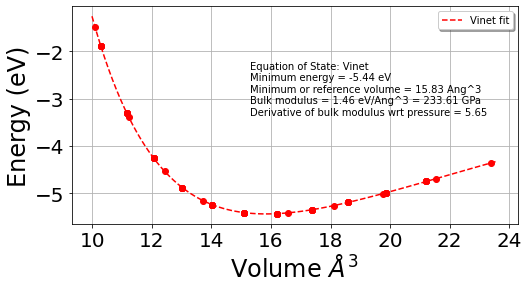

In [4]:
# Launch and Run!
deformations = [(np.identity(3) * (1 + x)).tolist() for x in np.linspace(-0.12, 0.12, 11)]

wf_eos = EOS_WF(structure=bulk_structure, deformations=deformations)
launchpad.add_wf(wf_eos)

rapidfire(launchpad)

In [ ]:
# Show EOS Plot


## **3.0 From Pt Bulk -> Pt (111) Surface**

In [ ]:
# Retrieve Equilibrium bulk structure from the DB


In [ ]:
# Slab Thickness Calibration
def SlabThickness_WF(structure, miller_index, repeat=[4,4,1], layers, vasp_cmd=VASP_CMD, db_file=DB_FILE):
    
    # Given a PMG structure object get conventional standard
    SGA = SpacegroupAnalyzer(structure)
    bulk_structure = SGA.get_conventional_standard_structure()
    
    # Get the slab model
    slab_list = []
    for n, layer in enumerate(layers):
        # Generate the slab model
        slab_gen = SlabGenerator(
                        bulk_structure,
                        miller_index=miller_index,
                        min_slab_size=layer,
                        min_vacuum_size=12,
                        in_unit_planes=True,
                        center_slab=True,
                        reorient_lattice=True,
                        lll_reduce=True)
        # Symmetrize
        slab = slab_gen.get_slabs(symmetrize=True, ftol=0.01)[0]
        # make supercell
        slab.make_supercell(repeat)
        # Append to slab_list
        slab_list.append(slab)
        
    # Theoretical method for slabs
    vis_slab_clean = TheoreticalLevelSet(structure=slab_list[0], 
                                         bulk=False, 
                                         user_incar_settings={"ENCUT": 420})
    
    # OptimizeFW for each surface
    fws = []
    for n, slab in enumerate(slab_list):
        
        if n == 0:
            fw = OptimizeFW(name=f"slab_thickness_{n}",
                            structure=slab,
                            vasp_input_set=vis_slab_clean,
                            max_force_threshold=None,
                            job_type="normal",
                            vasp_cmd=vasp_cmd,
                            db_file=db_file)
            fws.append(fw)
            
        else:
            fw = OptimizeFW(name=f"slab_thickness_{n}",
                            structure=slab,
                            vasp_input_set=vis_slab_clean,
                            max_force_threshold=None,
                            job_type="normal",
                            vasp_cmd=vasp_cmd,
                            db_file=db_file, parents=fws[n-1])
            fws.append(fw)
            
    # Post-processing slab_thickness
    parents = fws[1:]
    fw_analysis = Firework(SlabThicknessTask(db_file=db_file, to_db=True), name="Slab Thickness Analysis", parents=parents)
    
    # Wrap into a workflow
    wf_thick = Workflow(fws, name="Slab Thickness Workflow")
    return wf_thick

## **4.0 Surface+Adsorbate (Adsorption Energy)**

In [ ]:
# Adsorbate in a box (ref.)


## **5.0 Nudged Elastic Band (NEB)**

In [ ]:
# Maybe an H transfer or the methanol moving to another point of the surface
